<a href="https://colab.research.google.com/github/Gobihanath/DTect/blob/main/Dtect.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout,BatchNormalization
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
import cv2

input_shape = (256, 256, 3)  # 3 means the rgb format



## Importing Dataset from google drive

In [2]:
from google.colab import drive
drive.mount("/content/drive")



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
Image_Width = 256
Image_Height = 256
Image_Size = (Image_Width, Image_Height)
Image_Channel = 3
batch_size=32

# **Image Data Preprocessing**

In [4]:
data_set = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Dataset",
    seed=12,         #If you want to ensure that the shuffling of your dataset is the same across different runs, you can keep the seed value constant. If you don't care about reproducibility, you can omit the seed parameter or use a different value for each run.
    shuffle=True,
    image_size=Image_Size,
    batch_size=batch_size,
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False
)


Found 1200 files belonging to 6 classes.


In [5]:
class_names = data_set.class_names
class_names

['Bimesha 1', 'Bimesha 2', 'Gobi 1', 'Gobi 2', 'Gobi 3', 'Sajeeth1']

In [6]:
train_size = int(len(data_set)*.8)
val_size = int(len(data_set)*.1)
test_size = int(len(data_set)*.1)

In [7]:
train_size



30

## Dataset Partition

In [8]:
def get_dataset_partitions_tf(data_set, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(data_set)

    if shuffle:
        data_set = data_set.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = data_set.take(train_size)
    val_ds = data_set.skip(train_size).take(val_size)
    test_ds = data_set.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [9]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(data_set)

print(len(train_ds))
print(len(val_ds))
print(len(test_ds))

30
3
5


# Visualizing sample images

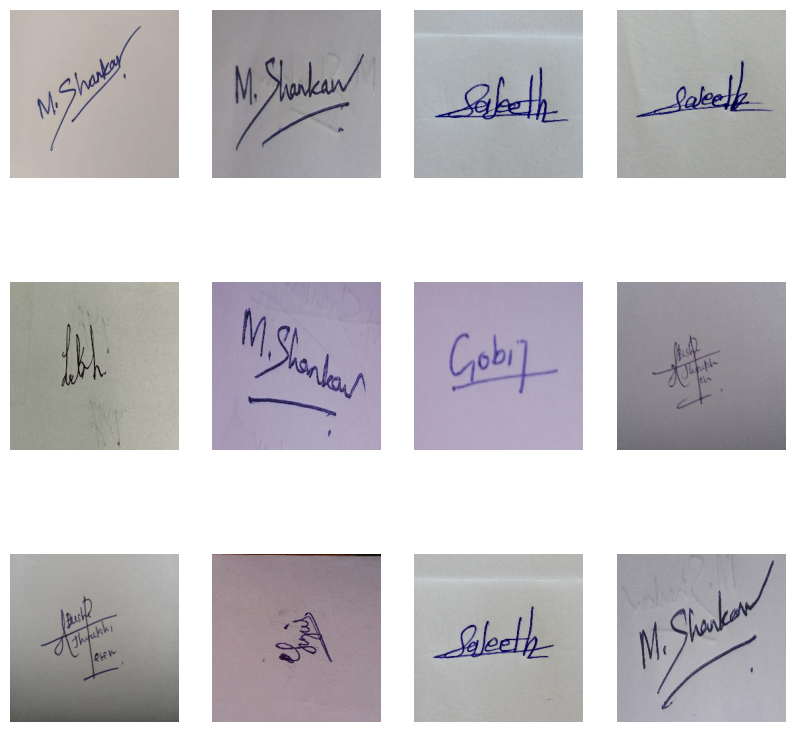

In [10]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in data_set.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.axis("off")

# Training, Validation,Testing Data Preprocessing

In [11]:
train_datagen = ImageDataGenerator(rotation_range=15,
                                  rescale=1./255,
                                  shear_range=0.1,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  width_shift_range=0.1,
                                  height_shift_range=0.1,)



test_datagen = ImageDataGenerator(rescale=1./255)


# Building The CNN model

In [12]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(Image_Size, Image_Size),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [11]:
model = Sequential()

model.add(Rescaling(1./255, input_shape=input_shape))
# add convolutional layers with pooling and dropout

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))

model.add(MaxPooling2D((2, 2)))

model.add(Dropout(0.25))


model.add(Conv2D(64, (3, 3), activation='relu'))

model.add(MaxPooling2D((2, 2)))

model.add(Dropout(0.25))


# flatten the output and add dense layers with dropout

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))


#This is the output layer

model.add(Dense(units=6, activation='softmax'))      #units=10 means we have 10 classes(signatures) softmax is used for
                                                     #now we have 6 classes

# compile the model
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

# print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 127, 127, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                   

# **Training and Validation**

In [12]:
history  = model.fit(
    train_ds,
    batch_size=32,
    validation_data=val_ds,
    validation_steps=6,
    verbose=1,
    epochs=10,
)

Epoch 1/10
30/30 [==============================] - ETA: 0s - loss: 5.0903 - accuracy: 0.2458

30/30 [==============================] - 204s 6s/step - loss: 5.0903 - accuracy: 0.2458 - val_loss: 1.6422 - val_accuracy: 0.4792
Epoch 2/10
30/30 [==============================] - 168s 4s/step - loss: 1.0344 - accuracy: 0.6176
Epoch 3/10
30/30 [==============================] - 165s 4s/step - loss: 0.5478 - accuracy: 0.8354
Epoch 4/10
30/30 [==============================] - 158s 4s/step - loss: 0.3778 - accuracy: 0.8782
Epoch 5/10
30/30 [==============================] - 158s 4s/step - loss: 0.2731 - accuracy: 0.9163
Epoch 6/10
30/30 [==============================] - 163s 4s/step - loss: 0.2699 - accuracy: 0.9258
Epoch 7/10
30/30 [==============================] - 161s 4s/step - loss: 0.1572 - accuracy: 0.9469
Epoch 8/10
30/30 [==============================] - 159s 4s/step - loss: 0.1345 - accuracy: 0.9481
Epoch 9/10
30/30 [==============================] - 174s 4s/step - loss: 0.1348 - accuracy: 0.9492
Epoch 10/10
30/30 [==============================] - 159s 4s/step - loss: 0.10

# Evaluating Model


In [13]:
train_loss, train_acc = model.evaluate(train_ds)
print('Training accuracy:', train_acc)

val_loss, val_acc = model.evaluate(val_ds)
print('Validation accuracy:', val_acc)

30/30 [==============================] - 77s 1s/step - loss: 0.1743 - accuracy: 0.9417
Training accuracy: 0.9416666626930237
3/3 [==============================] - 39s 881ms/step - loss: 0.2025 - accuracy: 0.8854
Validation accuracy: 0.8854166865348816


In [14]:
model.save('training_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Testing The Model

In [15]:
model= tf.keras.models.load_model('/content/training_model.h5')

In [20]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 67ms/step


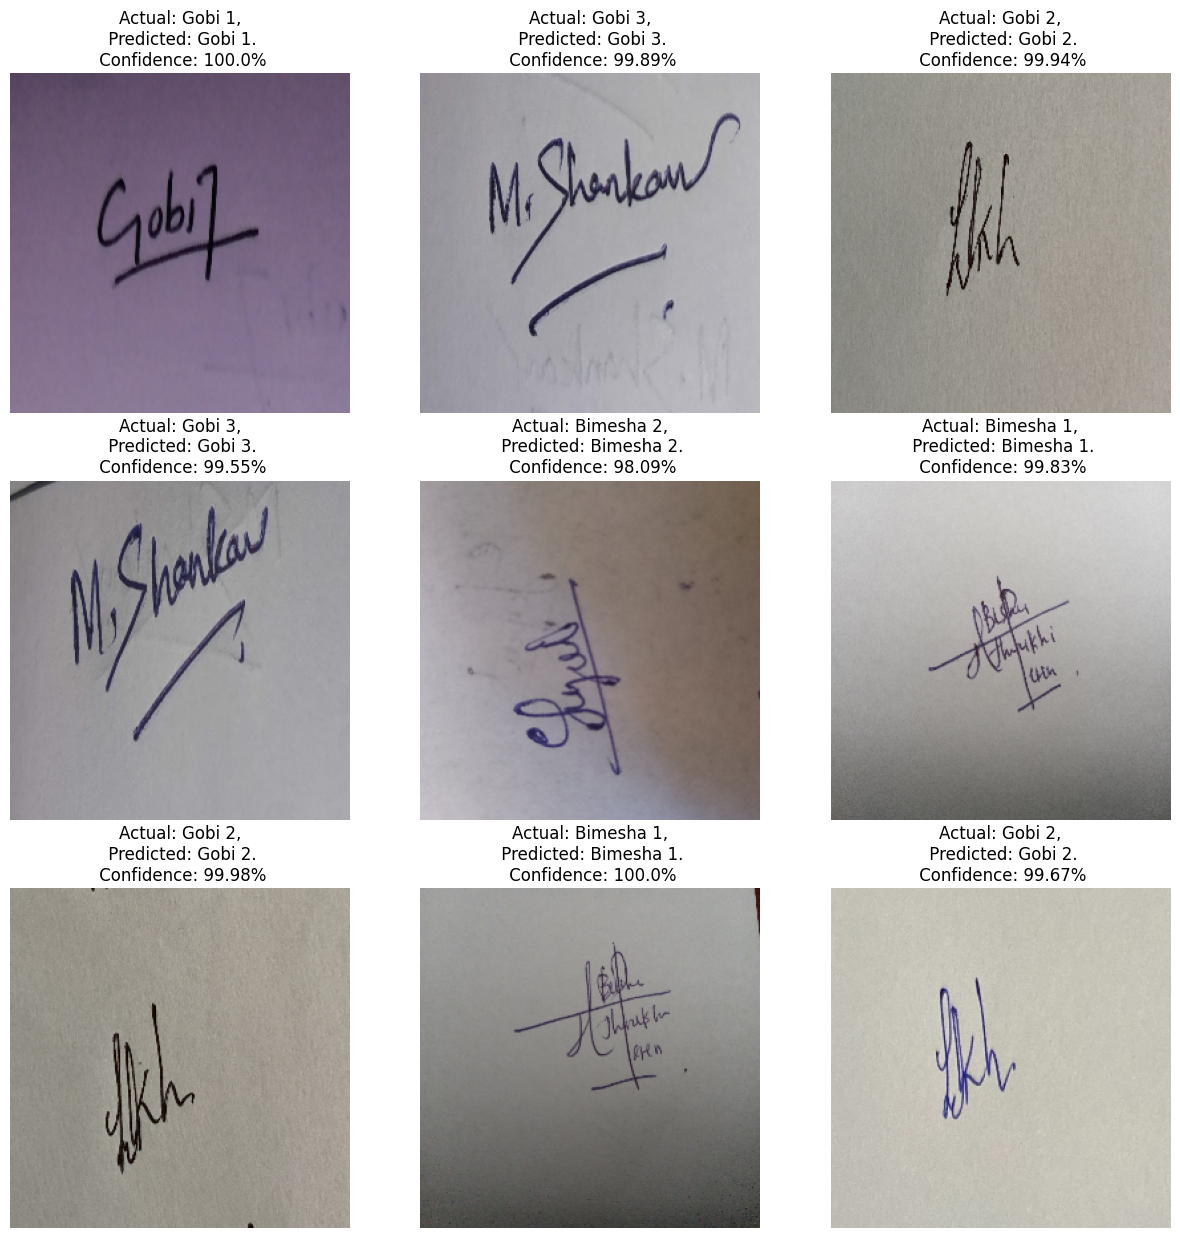

In [24]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i].numpy().argmax()]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")